In [8]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers


In [9]:
def load_devanagari_dataset(dataset_path):
    images = []
    labels = []
    label_dict = {"consonants": 0, "vowels": 1, "digits": 2}

    for folder in os.listdir(dataset_path):
        label = label_dict.get(folder)
        if label is not None:
            folder_path = os.path.join(dataset_path, folder)
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                if os.path.isfile(img_path):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (64, 64))  # Adjust the size as needed
                        img = img / 255.0  # Normalize pixel values to [0, 1]
                        images.append(img)
                        labels.append(label)

    return np.array(images), np.array(labels)


In [10]:
import os
import cv2
import numpy as np

def load_custom_dataset(dataset_path):
    images = []
    labels = []
    label_dict = {}  # Mapping from class name to label

    for label, class_name in enumerate(os.listdir(dataset_path)):
        label_dict[class_name] = label
        class_path = os.path.join(dataset_path, class_name)

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (64, 64))  # Adjust the size as needed
                img = img / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels, label_dict

# Example usage
dataset_path = "Downloads/images"
X, y, label_dict = load_custom_dataset(dataset_path)


In [11]:
# Assuming you have already loaded the dataset using the provided function
# X, y = load_devanagari_dataset(dataset_path)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Reshape the data for compatibility with Conv2D layers
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 1)


# Print the shapes of the sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (73600, 64, 64, 1)
y_train shape: (73600, 46)
X_test shape: (18400, 64, 64, 1)
y_test shape: (18400, 46)


In [12]:
# Import necessary libraries
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers from the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the VGG16 base followed by custom dense layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(46, activation='softmax'))  
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Ensure correct input shape (convert grayscale to RGB)
X_train_rgb = np.repeat(X_train, 3, -1)
X_test_rgb = np.repeat(X_test, 3, -1)

# Load the pre-trained VGG16 model with the correct input shape
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# ... (rest of your code)
# Freeze the layers from the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the VGG16 base followed by custom dense layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(46, activation='softmax'))  
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Train the model
history = model.fit(X_train_rgb, y_train, epochs=10, batch_size=32, validation_data=(X_test_rgb, y_test))

Epoch 1/10
2300/2300 [==============================] - 470s 204ms/step - loss: 0.5287 - accuracy: 0.8638 - val_loss: 0.2159 - val_accuracy: 0.9387
Epoch 2/10
2300/2300 [==============================] - 452s 197ms/step - loss: 0.1659 - accuracy: 0.9512 - val_loss: 0.1683 - val_accuracy: 0.9476
Epoch 3/10
2300/2300 [==============================] - 451s 196ms/step - loss: 0.1134 - accuracy: 0.9659 - val_loss: 0.1336 - val_accuracy: 0.9586
Epoch 4/10
2300/2300 [==============================] - 456s 198ms/step - loss: 0.0900 - accuracy: 0.9712 - val_loss: 0.1245 - val_accuracy: 0.9616
Epoch 5/10
2300/2300 [==============================] - 452s 197ms/step - loss: 0.0769 - accuracy: 0.9756 - val_loss: 0.1216 - val_accuracy: 0.9638
Epoch 6/10
2300/2300 [==============================] - 451s 196ms/step - loss: 0.0650 - accuracy: 0.9792 - val_loss: 0.0994 - val_accuracy: 0.9691
Epoch 7/10
2300/2300 [==============================] - 451s 196ms/step - loss: 0.0532 - accuracy: 0.9822 - val_

In [18]:
test_loss, test_acc = model.evaluate(X_test_rgb, y_test)
print(f'Test Accuracy: {test_acc*100}')

575/575 [==============================] - 142s 247ms/step - loss: 0.1125 - accuracy: 0.9686
Test Accuracy: 96.86412811279297


In [19]:
model.save('vgg_deva_vikram.h5')

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


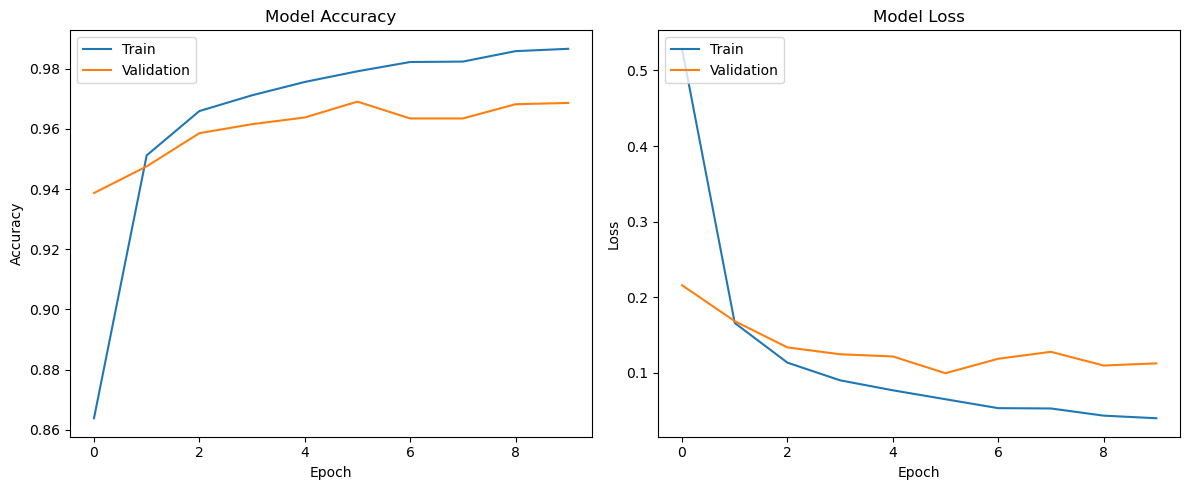

In [20]:
import matplotlib.pyplot as plt
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Display the plot
plot_history(history)

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming your model is already trained and has made predictions on the test set
y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


575/575 [==============================] - 141s 245ms/step


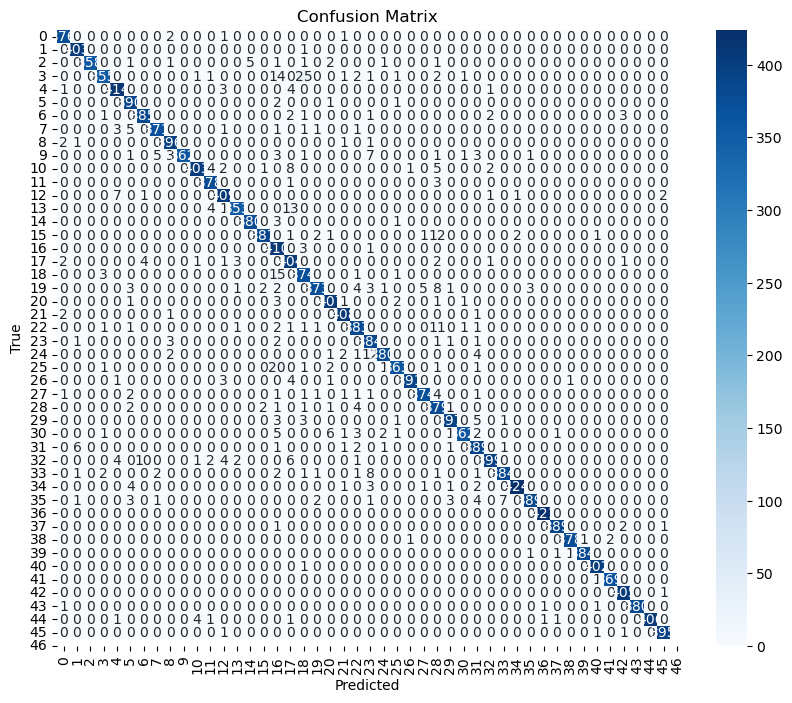

In [23]:
# Generate confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
class_names= {0: 'क', 1: 'ख', 2: 'ग', 3: 'घ', 4: 'ङ', 5: 'च', 6: 'छ', 7: 'ज', 8: 'झ', 9: 'ञ', 10: 'ट', 11: 'ठ', 12: 'ड', 13: 'ढ', 14: 'ण', 15: 'त', 16: 'थ', 17: 'द', 18: 'ध', 19: 'न', 20: 'प', 21: 'फ', 22: 'ब', 23: 'भ', 24: 'म', 25: 'य', 26: 'र', 27: 'ल', 28: 'व', 29: 'श', 30: 'ष', 31: 'स', 32: 'ह', 33: 'क्ष', 34: 'त्र', 35: 'ज्ञ', 36: 'अ', 37: 'आ', 38: 'इ', 39: 'ई', 40: 'उ', 41: 'ऊ', 42: 'ऋ', 43: 'ए', 44: 'ऐ', 45: 'ओ', 46: 'औ'}

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [1]:
#####################################  word  prediction ######################################

import cv2
import pytesseract
import os
from googletrans import Translator

# Path to the Tesseract executable (update it based on your installation)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Set the tessdata directory
tessdata_dir = r'C:\Program Files\Tesseract-OCR\tessdata'
os.environ['TESSDATA_PREFIX'] = tessdata_dir

def predict_devanagari_word(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use adaptive thresholding to preprocess the image
    _, thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Use Tesseract OCR to extract text from the image
    custom_config = r'--oem 3 --psm 6 outputbase digits -c tessedit_char_whitelist=ऀ-ॿ'
    
    try:
        detected_text = pytesseract.image_to_string(img, lang='hin+deva')
        return detected_text
    except Exception as e:
        print("Error during OCR:")
        print(e)
        return None

# Path to the image file you want to predict
image_path = r'Downloads/testrat.png'  # Replace with the actual path

# Predict the Devanagari word
predicted_word = predict_devanagari_word(image_path)

# Display the predicted word
if predicted_word:
    print(f'Predicted Devanagari Word: {predicted_word}')
else:
    print('Failed to predict Devanagari word.')

Predicted Devanagari Word: शक्ति अबिरामी



In [2]:
from googletrans import Translator

translator = Translator()

out = translator.translate(predicted_word, dest=input("Enter the language code to translate : "))

print("After translate=", out.text)

Enter the language code to translate : en
After translate= Shakti Abirami
